In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
np.random.seed(42)

In [2]:
def get_data():
    # 读取数据并处理数据
    path = "Z:\data\BTCUSDT\BTCUSDT-1h"
    filelist = os.listdir(path)
    filelist.sort()
    df = pd.DataFrame()
    for i in tqdm(filelist[-300:]):
        df0 = pd.read_csv(os.path.join(path, i))
        df = pd.concat([df, df0])
    df1 = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]
    df1.columns = ['t', 'o', 'h', 'l', 'c', 'v']
    df1 = df1.dropna()
    return df1


# 1.首先读取数据
df = get_data()

100%|██████████| 300/300 [00:05<00:00, 58.13it/s]


In [3]:
def create_features(df):
    """
    创建用于预测的特征

    参数:
    df (pandas.DataFrame): 包含股票数据的DataFrame

    返回:
    pandas.DataFrame: 包含特征的DataFrame
    """
    df_feat = df.copy()

    # 创建滞后特征
    for i in range(1, 6):  # 1到5天的滞后
        if i == 1:  # 如果是当前时刻，就继续
            continue
        df_feat[f'lag_{i}'] = df_feat['c'].shift(i - 1)

    # 创建移动平均特征
    df_feat['MA_5'] = df_feat['c'].rolling(window=5).mean()
    df_feat['MA_10'] = df_feat['c'].rolling(window=10).mean()
    df_feat['MA_20'] = df_feat['c'].rolling(window=20).mean()

    # 创建波动率特征
    df_feat['Volatility_5'] = df_feat['c'].rolling(window=5).std()
    df_feat['Volatility_10'] = df_feat['c'].rolling(window=10).std()

    # 创建涨跌特征
    df_feat['Return'] = df_feat['c'].pct_change()
    df_feat['Return_prev'] = df_feat['Return'].shift(1)
    df_feat['Return_prev_2'] = df_feat['Return'].shift(2)

    # 创建价格变动特征
    df_feat['Price_change'] = df_feat['c'] - df_feat['o']
    df_feat['High_low'] = df_feat['h'] - df_feat['l']

    # RSI指标
    delta = df_feat['c'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_feat['rsi'] = 100 - (100 / (1 + rs))

    # MACD指标
    df_feat['ema_12'] = df_feat['c'].ewm(span=12, adjust=False).mean()
    df_feat['ema_26'] = df_feat['c'].ewm(span=26, adjust=False).mean()
    df_feat['macd'] = df_feat['ema_12'] - df_feat['ema_26']
    df_feat['macd_signal'] = df_feat['macd'].ewm(span=9, adjust=False).mean()
    df_feat['macd_hist'] = df_feat['macd'] - df_feat['macd_signal']

    # 将当前时刻的c值，往前一段时间移动一位，即让未来时刻的数据作为当前时刻的预测目标
    df_feat['diff'] = df_feat['c'].shift(-1) - df_feat['c']
    df_feat.loc[df_feat['diff'] > 0, 'target'] = 1  # 上涨标记为1
    df_feat.loc[df_feat['diff'] <= 0, 'target'] = -1  # 下跌或持平标记为-1

    df_feat = df_feat.drop('diff', axis=1)
    # 删除包含NaN的行
    df_feat = df_feat.dropna()
    df_feat = df_feat.reset_index(drop=True)  # 修正：添加drop=True避免保留原索引

    return df_feat


# 2.对数据进行特征提取
df_feat = create_features(df=df)
df2 = df_feat.copy()

In [4]:
def split_data(df, target_col, test_size=0.2):
    """
    划分数据集为训练集和测试集

    参数:
    df (pandas.DataFrame): 包含特征和目标变量的DataFrame
    target_col (str): 目标变量列名
    test_size (float): 测试集比例，默认为0.2

    返回:
    tuple: 包含训练集特征、测试集特征、训练集目标、测试集目标的元组
    """
    # 确保不包含日期列
    X = df.drop([target_col, 't'], axis=1) if 't' in df.columns else df.drop([target_col], axis=1)
    y = df[target_col]

    # 转换为NumPy数组
    X = X.values
    y = y.values

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test


# 3.划分数据集
dates = pd.to_datetime(df2['t'], unit='ms')  # 获得时间序列
X_train, X_test, y_train, y_test = split_data(df2, 'target', test_size=0.3)

In [5]:
# 4.保存特征名称用于特征重要性分析
feature_names = df2.drop(['target', 't'], axis=1).columns.tolist()

In [6]:
def standar(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


# 5.对数据进行标准化
X_train_scaled, X_test_scaled = standar(X_train, X_test)  # 返回标准化后的数据

In [7]:
def train_lightgbm_model(train_data, test_data, X_test_scaled, y_test):
    # 设置参数，使用multiclass目标并设置num_class=2
    params = {
        'objective': 'multiclass',
        'num_class': 2,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 42,
        'is_unbalance': True  # 金融数据通常存在类别不平衡
    }

    # 训练模型
    num_round = 100
    model = lgb.train(
        params,
        train_data,
        num_round,
        valid_sets=[test_data]
    )
    return model
# 创建LightGBM数据集
# 将-1/1标签映射为0/1，因为LightGBM需要从0开始的类别索引
y_train_mapped = np.where(y_train == 1, 1, 0)
y_test_mapped = np.where(y_test == 1, 1, 0)

train_data = lgb.Dataset(X_train_scaled, label=y_train_mapped)
test_data = lgb.Dataset(X_test_scaled, label=y_test_mapped, reference=train_data)
# 6.训练LightGBM模型
model = train_lightgbm_model(train_data, test_data, X_test_scaled, y_test)

In [8]:
def predict_model(model,X_test_scaled,y_test):
    # 预测
    y_pred_proba = model.predict(X_test_scaled)
    # 获取预测类别索引
    # y_pred_index = np.argmax(y_pred_proba, axis=1)
    # 取出“上涨类”的概率（因为模型输出是 [下跌概率, 上涨概率]，所以取第二列，索引 1）
    y_pred_proba_pos = y_pred_proba[:, 1]

    # 【关键】手动设置阈值，比如 threshold = 0.6
    threshold = 0.47
    # 将类别索引映射回-1和1
    y_pred = np.where(y_pred_proba_pos > threshold, 1, -1)

    # 评估模型
    accuracy = accuracy_score(y_test, y_pred)
    # 计算精确率、召回率和F1分数时，指定average='binary'和pos_label=1
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)

    # 计算ROC AUC，需要将-1/1转换为0/1
    y_test_binary = np.where(y_test == 1, 1, 0)
    # 取类别1的概率作为正类概率
    y_pred_proba_pos = y_pred_proba[:, 1]
    roc_auc = roc_auc_score(y_test_binary, y_pred_proba_pos)

    # 打印主要评估指标
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率 (上涨): {precision:.4f}")
    print(f"召回率 (上涨): {recall:.4f}")
    print(f"F1分数 (上涨): {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    return y_pred

y_pred=predict_model(model,X_test_scaled, y_test)

准确率: 0.5432
精确率 (上涨): 0.5375
召回率 (上涨): 0.7260
F1分数 (上涨): 0.6177
AUC: 0.5533


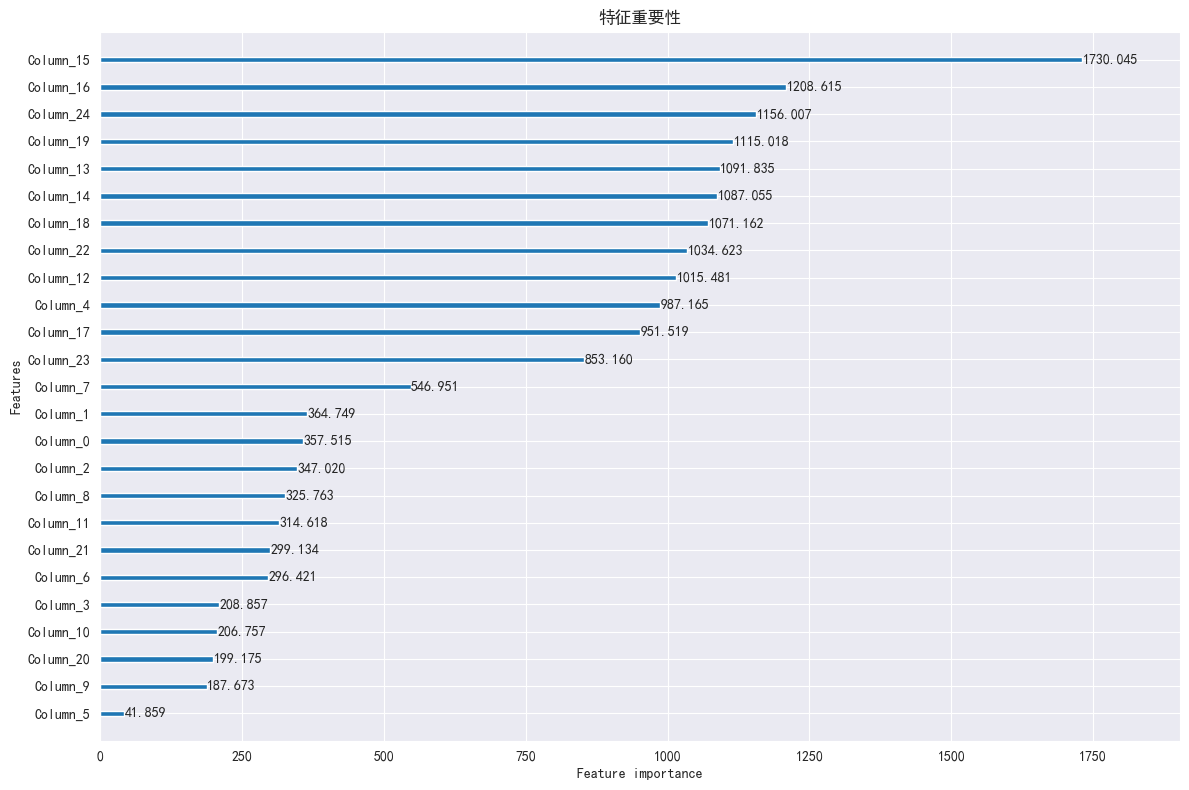

特征重要性:
          Feature   Importance
15    Return_prev  1730.045330
16  Return_prev_2  1208.614622
24      macd_hist  1156.007371
19            rsi  1115.018474
13  Volatility_10  1091.835150
14         Return  1087.054898
18       High_low  1071.162478
22           macd  1034.623188
12   Volatility_5  1015.481064
4               v   987.164874
17   Price_change   951.518640
23    macd_signal   853.160320
7           lag_4   546.951490
1               h   364.749079
0               o   357.514800
2               l   347.019809
8           lag_5   325.763493
11          MA_20   314.617560
21         ema_26   299.134190
6           lag_3   296.420670
3               c   208.857036
10          MA_10   206.756994
20         ema_12   199.174820
9            MA_5   187.672934
5           lag_2    41.858740


In [9]:
def plot_feature_importance(model, feature_names):
    """
    可视化特征重要性

    参数:
    model (lgb.Booster): 训练好的LightGBM模型
    feature_names (list): 特征名称列表
    """
    lgb.plot_importance(model, importance_type='gain', figsize=(12, 8))
    plt.title('特征重要性')
    plt.tight_layout()
    plt.show()

    # 打印特征重要性分数
    importance = model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("特征重要性:")
    print(feature_importance)


# 8.可视化特征重要性
plot_feature_importance(model, feature_names)

In [10]:
# 接下来是做回测数据，首先用数据进行预测
train_size = len(y_train)
df_predict = df_feat.iloc[train_size:, :]
x_predict = df_predict.drop('target', axis=1)
x_predict = x_predict.drop('t', axis=1)

# 对预测的特征进行标准化处理
scaler = StandardScaler()
x_predict_scaled = scaler.fit_transform(x_predict)
#
y_predict_scaled= model.predict(x_predict_scaled)
# 取出“上涨类”的概率（因为模型输出是 [下跌概率, 上涨概率]，所以取第二列，索引 1）
y_predict_scaled = y_predict_scaled[:, 1]
threshold = 0.47
# 将类别索引映射回-1和1
df_predict['target_predict'] = np.where(y_predict_scaled > threshold, 1, -1)
df_predict

,t,o,h,l,c,v,lag_2,lag_3,lag_4,lag_5,...,Price_change,High_low,rsi,ema_12,ema_26,macd,macd_signal,macd_hist,target,target_predict
5026,1689138000000,30623.9,30688.7,30600.0,30642.5,7630.501,30623.9,30581.3,30599.0,30518.9,...,18.6,88.7,54.277995,30573.633095,30525.800065,47.833030,45.601991,2.231039,1.0,-1
5027,1689141600000,30642.5,30786.0,30600.4,30706.6,17425.423,30642.5,30623.9,30581.3,30599.0,...,64.1,185.6,55.519860,30594.089542,30539.192653,54.896889,47.460971,7.435918,1.0,-1
5028,1689145200000,30706.6,30849.2,30699.0,30730.8,19690.812,30706.6,30642.5,30623.9,30581.3,...,24.2,150.2,62.853590,30615.121920,30553.385790,61.736130,50.316003,11.420128,-1.0,-1
5029,1689148800000,30730.7,30750.6,30660.0,30720.5,11261.656,30730.8,30706.6,30642.5,30623.9,...,-10.2,90.6,73.540644,30631.333932,30565.764620,65.569312,53.366665,12.202648,-1.0,-1
5030,1689152400000,30720.5,30748.8,30670.0,30710.0,5755.926,30720.5,30730.8,30706.6,30642.5,...,-10.5,78.8,65.826944,30643.436404,30576.448722,66.987682,56.090868,10.896814,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7175,1696874400000,27582.6,27739.6,27550.8,27554.9,25625.567,27582.6,27391.1,27433.0,27486.6,...,-27.7,188.8,31.619067,27563.001718,27668.305817,-105.304099,-94.975185,-10.328914,1.0,-1
7176,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886,27554.9,27582.6,27391.1,27433.0,...,52.6,106.1,37.439539,27569.862992,27663.809090,-93.946098,-94.769368,0.823270,-1.0,1
7177,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344,27607.6,27554.9,27582.6,27391.1,...,-51.5,101.1,32.991158,27567.760993,27655.838046,-88.077053,-93.430905,5.353852,1.0,1
7178,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588,27556.2,27607.6,27554.9,27582.6,...,51.3,84.9,39.607926,27573.859302,27652.250043,-78.390741,-90.422872,12.032131,-1.0,1


In [11]:
df_predict=df_predict[['t','c','target_predict']]

In [12]:
# 创建一个存储做空做满的列表
strategy_list = []  #[]
strategy_single_list = [0, 0, 0, 0]  # [t,oc,cc,judge]


def get_strategy(df):
    strategy = 0
    global strategy_single_list, strategy_list
    for row in df.itertuples():
        if row.target_predict == 1.0 and strategy == 0:
            strategy = 1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if row.target_predict == -1.0 and strategy == 0:
            strategy = -1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if strategy == 1 and row.target_predict == -1.0:  # 说明要进行盈亏了
            strategy_single_list[2] = row.c
            strategy_list.append(strategy_single_list.copy())
            strategy = -1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if strategy == -1 and row.target_predict == 1.0:  # 说明要进行盈利亏了
            strategy_single_list[2] = row.c
            strategy_list.append(strategy_single_list.copy())
            strategy = 1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy


get_strategy(df_predict)
strategy_list

[[1689138000000, 30642.5, 30671.9, -1],
 [1689156000000, 30671.9, 30765.3, 1],
 [1689159600000, 30765.3, 30510.2, -1],
 [1689174000000, 30510.2, 30350.1, 1],
 [1689199200000, 30350.1, 30283.7, -1],
 [1689217200000, 30283.7, 30284.5, 1],
 [1689220800000, 30284.5, 31364.9, -1],
 [1689278400000, 31364.9, 31243.9, 1],
 [1689282000000, 31243.9, 31378.3, -1],
 [1689307200000, 31378.3, 31173.0, 1],
 [1689328800000, 31173.0, 31122.6, -1],
 [1689336000000, 31122.6, 31251.0, 1],
 [1689339600000, 31251.0, 30674.9, -1],
 [1689354000000, 30674.9, 30224.4, 1],
 [1689368400000, 30224.4, 30208.0, -1],
 [1689372000000, 30208.0, 30293.3, 1],
 [1689375600000, 30293.3, 30315.0, -1],
 [1689379200000, 30315.0, 30323.0, 1],
 [1689382800000, 30323.0, 30277.8, -1],
 [1689386400000, 30277.8, 30276.0, 1],
 [1689390000000, 30276.0, 30174.1, -1],
 [1689476400000, 30174.1, 30143.6, 1],
 [1689480000000, 30143.6, 29870.0, -1],
 [1689620400000, 29870.0, 29907.1, 1],
 [1689624000000, 29907.1, 30096.3, -1],
 [1689631200

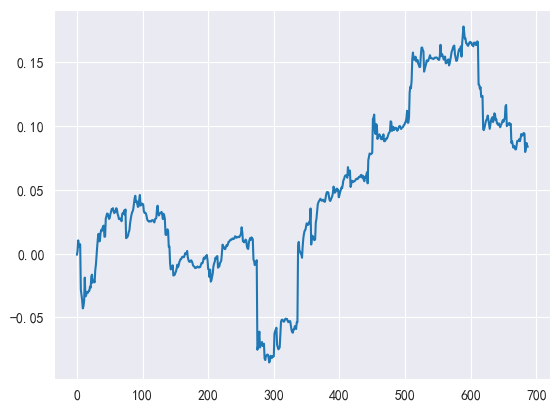

In [13]:
# 绘制收益曲线
trade_df = pd.DataFrame(strategy_list)
trade_df['profit'] = (trade_df[2] - trade_df[1]) / trade_df[1] * trade_df[3]
plt.plot(trade_df['profit'].cumsum())

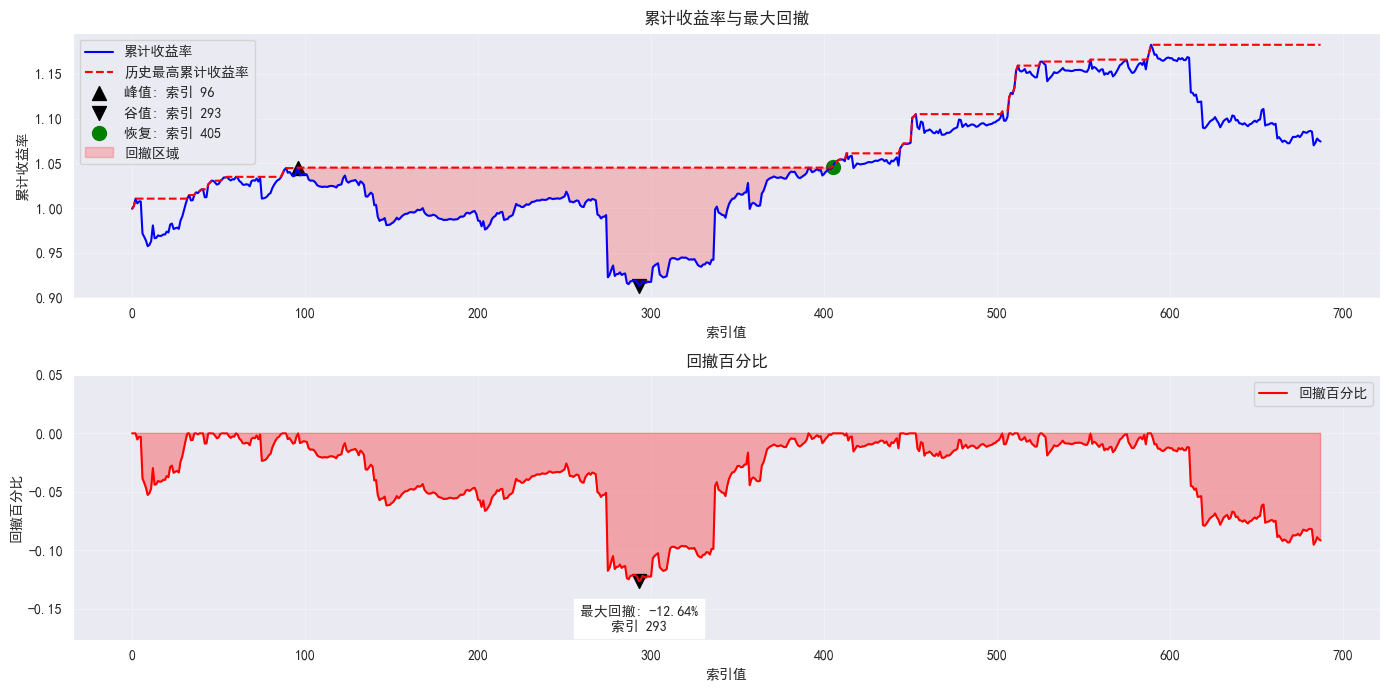

最大回撤: -12.64%
峰值位置: 索引 96
谷值位置: 索引 293
恢复位置: 索引 405
回撤持续长度: 309个周期


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经有一个名为trade_df的DataFrame，其中包含'profit'列
# 下面的代码将直接使用你的trade_df进行分析

# 计算累计收益率
trade_df['cumulative_return'] = (1 + trade_df['profit']).cumprod()

# 计算滚动最高值(用于最大回撤计算)
trade_df['rolling_max'] = trade_df['cumulative_return'].cummax()

# 计算回撤(当前值与历史最高值的差值)
trade_df['drawdown'] = trade_df['cumulative_return'] / trade_df['rolling_max'] - 1

# 计算最大回撤
max_drawdown = trade_df['drawdown'].min()
max_drawdown_idx = trade_df['drawdown'].idxmin()

# 计算从最高点到最低点的索引
peak_idx = trade_df.loc[:max_drawdown_idx, 'cumulative_return'].idxmax()
recovery_idx = None

# 寻找回撤恢复索引(如果有的话)
if max_drawdown < 0:
    post_drawdown_returns = trade_df.loc[max_drawdown_idx:, 'cumulative_return']
    if not post_drawdown_returns.empty:
        recovery_idx = \
            post_drawdown_returns[post_drawdown_returns >= trade_df['rolling_max'].loc[max_drawdown_idx]].index[
                0] if any(
                post_drawdown_returns >= trade_df['rolling_max'].loc[max_drawdown_idx]) else None

# 绘制最大收益率回测图
plt.figure(figsize=(14, 7))

# 绘制累计收益率曲线
plt.subplot(2, 1, 1)
plt.plot(trade_df['cumulative_return'], label='累计收益率', color='blue')
plt.plot(trade_df['rolling_max'], label='历史最高累计收益率', color='red', linestyle='--')

# 标记最大回撤的峰值和谷值
if max_drawdown < 0:
    plt.scatter(peak_idx, trade_df['cumulative_return'].loc[peak_idx],
                color='black', s=100, marker='^', label=f'峰值: 索引 {peak_idx}')
    plt.scatter(max_drawdown_idx, trade_df['cumulative_return'].loc[max_drawdown_idx],
                color='black', s=100, marker='v', label=f'谷值: 索引 {max_drawdown_idx}')

    # 如果有恢复索引，标记恢复点
    if recovery_idx:
        plt.scatter(recovery_idx, trade_df['cumulative_return'].loc[recovery_idx],
                    color='green', s=100, marker='o', label=f'恢复: 索引 {recovery_idx}')

        # 填充回撤区域
        plt.fill_between(
            trade_df.loc[peak_idx:recovery_idx].index,
            trade_df.loc[peak_idx:recovery_idx, 'cumulative_return'],
            trade_df.loc[peak_idx:recovery_idx, 'rolling_max'],
            color='red', alpha=0.2, label='回撤区域'
        )
    else:
        # 填充未恢复的回撤区域
        plt.fill_between(
            trade_df.loc[peak_idx:].index,
            trade_df.loc[peak_idx:, 'cumulative_return'],
            trade_df.loc[peak_idx:, 'rolling_max'],
            color='red', alpha=0.2, label='回撤区域(未恢复)'
        )

plt.title('累计收益率与最大回撤')
plt.xlabel('索引值')
plt.ylabel('累计收益率')
plt.legend()
plt.grid(True, alpha=0.3)

# 绘制回撤百分比图
plt.subplot(2, 1, 2)
plt.fill_between(trade_df.index, trade_df['drawdown'], 0,
                 where=trade_df['drawdown'] < 0, color='red', alpha=0.3)
plt.plot(trade_df.index, trade_df['drawdown'], color='red', label='回撤百分比')

# 标记最大回撤点
if max_drawdown < 0:
    plt.scatter(max_drawdown_idx, max_drawdown, color='black', s=100, marker='v')
    plt.text(max_drawdown_idx, max_drawdown - 0.02,
             f'最大回撤: {max_drawdown * 100:.2f}%\n索引 {max_drawdown_idx}',
             ha='center', va='top', backgroundcolor='white')

plt.title('回撤百分比')
plt.xlabel('索引值')
plt.ylabel('回撤百分比')
plt.ylim(bottom=min(trade_df['drawdown']) - 0.05, top=0.05)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 输出最大回撤信息
print(f"最大回撤: {max_drawdown * 100:.2f}%")
print(f"峰值位置: 索引 {peak_idx}")
print(f"谷值位置: 索引 {max_drawdown_idx}")

if recovery_idx:
    recovery_length = recovery_idx - peak_idx
    print(f"恢复位置: 索引 {recovery_idx}")
    print(f"回撤持续长度: {recovery_length}个周期")
else:
    print("截至最新位置，回撤尚未恢复")

In [15]:
|

SyntaxError: invalid syntax (2873296125.py, line 1)